# Periodic systems in Grad DFT

In this tutorial, you will learn how to train a simple neural functional for solids. Presently, we only support periodic calculations where Brillouin Zone (BZ) samping is performed at the $\Gamma$-point. This converges the electronic structure only at the large supercell limit. We won't work with large supercells in this tutorial, so for accurate results, please consider this.

Full BZ sampling will be coming soon.

## Perform solid-state calculations with PySCF

PySCF implements DFT and some wavefunction methods in periodic boundary conditions with integration over the first BZ. To begin, we need:

(1) A DFT starting point to prime Grad DFT. Let's use the LDA.

(2) Accurate training and validation data. We'll use the periodic Coupled Cluster Singles and Doubles (CCSD) implemented in PySCF

Our calculations will be run using carbon in the diamond structure.

In [1]:
# DFT

from pyscf.pbc import gto, scf
import numpy as np

# Training geometry
cell_tr = gto.M(
    a = np.eye(3)*3.5668,
    atom = '''C     0.      0.      0.    
              C     0.8917  0.8917  0.8917
              C     1.7834  1.7834  0.    
              C     2.6751  2.6751  0.8917
              C     1.7834  0.      1.7834
              C     2.6751  0.8917  2.6751
              C     0.      1.7834  1.7834
              C     0.8917  2.6751  2.6751''',
    basis = 'sto-3g',
    pseudo = 'gth-pade',
)

# Validation geometry: cell expanded by 3%
cell_val = gto.M(
    a = np.eye(3)*3.5668*1.03,
    atom = '''C     0.      0.      0.    
              C     0.8917  0.8917  0.8917
              C     1.7834  1.7834  0.    
              C     2.6751  2.6751  0.8917
              C     1.7834  0.      1.7834
              C     2.6751  0.8917  2.6751
              C     0.      1.7834  1.7834
              C     0.8917  2.6751  2.6751''',
    basis = 'sto-3g',
    pseudo = 'gth-pade',
)

# Run training DFT starting point
kmf_tr = scf.KRKS(cell_tr, kpts=cell_tr.make_kpts([1,1,1])).density_fit()
kmf_tr.xc = "LDA"
kmf_tr = kmf_tr.run()

# Run validation DFT starting point
kmf_val = scf.KRKS(cell_val, kpts=cell_val.make_kpts([1,1,1])).density_fit()
kmf_val.xc = "LDA"
kmf_val = kmf_val.run()

/Users/jack.baker/miniconda3/envs/nan_check/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
<class 'pyscf.pbc.dft.krks.KRKS'> does not have attributes  nlcgrids nlc


converged SCF energy = -42.8062140980971
converged SCF energy = -42.8206602020094


In [2]:
# Make one training data-point and one validation using CCSD
from pyscf import cc

# Training
khf_tr = scf.RHF(cell_tr).density_fit()
khf_tr.kernel()
mycc_tr = cc.CCSD(khf_tr)
mycc_tr.kernel()
E_tr = mycc_tr.e_tot

# Validation
khf_val = scf.RHF(cell_val).density_fit()
khf_val.kernel()
mycc_val = cc.CCSD(khf_val)
mycc_val.kernel()
E_val = mycc_val.e_tot


converged SCF energy = -43.6458490406153
E(RCCSD) = -43.96945435783168  E_corr = -0.3236053172163934
converged SCF energy = -43.6169208430434
E(RCCSD) = -43.96249507025142  E_corr = -0.3455742272080577


## Loading into Grad DFT

When performing $\Gamma$-point calculations, workflows in Grad DFT are no different to the molcular case with open boundary conditions. We can therefor make a Grad DFT `Molecule` just as like we did with molecular systems

In [3]:
import grad_dft as gd

gd_mol_tr = gd.molecule_from_pyscf(kmf_tr)
gd_mol_val = gd.molecule_from_pyscf(kmf_val)

Instructions for updating:
non-resource variables are not supported in the long term


I0000 00:00:1698444195.665811       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
Instructions for updating:
non-resource variables are not supported in the long term


## Make a simple neural functional

Like in `~/examples/intermediate_notebooks/training_methods_03.ipynb`, we create a scaled down version of the net used the original Grad DFT reference article

In [4]:
from grad_dft.functional import canonicalize_inputs, dm21_coefficient_inputs, dm21_densities
from jax.nn import gelu
from functools import partial
import jax.numpy as jnp
from jax.random import PRNGKey

seed = 1984 # Random seed used throughout this notebok for reproducibility reasons.
key = PRNGKey(seed)

squash_offset = 1e-4
layer_widths = [6] * 2

out_features = 2
sigmoid_scale_factor = 2.0
activation = gelu

def nn_coefficients(instance, rhoinputs, *_, **__):
    x = canonicalize_inputs(rhoinputs)  # Making sure dimensions are correct
    # Initial layer: log -> dense -> tanh
    x = jnp.log(jnp.abs(x) + squash_offset)  # squash_offset = 1e-4
    instance.sow("intermediates", "log", x)
    x = instance.dense(features=layer_widths[0])(x)  # features = 256
    instance.sow("intermediates", "initial_dense", x)
    x = jnp.tanh(x)
    instance.sow("intermediates", "norm", x)
    # 2 Residual blocks with 6-features dense layer and layer norm
    for features, i in zip(layer_widths, range(len(layer_widths))):  # layer_widths = [256]*6
        res = x
        x = instance.dense(features=features)(x)
        instance.sow("intermediates", "residual_dense_" + str(i), x)
        x = x + res  # nn.Dense + Residual connection
        instance.sow("intermediates", "residual_residual_" + str(i), x)
        x = instance.layer_norm()(x)  # + res # nn.LayerNorm
        instance.sow("intermediates", "residual_layernorm_" + str(i), x)
        x = activation(x)  # activation = jax.nn.gelu
        instance.sow("intermediates", "residual_elu_" + str(i), x)
    return instance.head(x, out_features, sigmoid_scale_factor)
        
functional = gd.NeuralFunctional(
    coefficients=nn_coefficients,
    coefficient_inputs=dm21_coefficient_inputs,
    energy_densities=partial(dm21_densities, functional_type="GGA"),
)

## Non self-consistent training using the energy only

Once again, borrowing from `~/examples/intermediate_notebooks/training_methods_03.ipynb`, we define a training and validation regime

In [5]:
from optax import adam, apply_updates
from tqdm import tqdm
from jax import value_and_grad

def train_neural_functional(train_recipe: tuple, validate_recipe: tuple) -> None:
    r"""Minimize a Grad DFT loss function using 50 epochs of the Adam optimizer.

    Args:
        train_recipe (tuple):train_recipe (tuple): information regarding the loss, its arguments and the predictor.
        validate_recipe (tuple):train_recipe (tuple): the same information as train_recipe, but for the validation calculation.
    Returns:
        tuple: the training and validation loss history over the number of training epochs
    """
    
    loss_func, loss_args = train_recipe
    val_func, val_args = validate_recipe
    
    tr_params = functional.init(key, dm21_coefficient_inputs(loss_args[2][0]))
    loss_args[0] = tr_params
    val_args[0] = tr_params
    
    tx = adam(learning_rate=0.01, b1=0.9)
    opt_state = tx.init(tr_params)
    loss_and_grad = value_and_grad(loss_func)
    tr_loss_history = []
    val_loss_history = []
    for i in tqdm(range(50), desc="Training epoch"):
        tr_loss_value, grads = loss_and_grad(*loss_args)
        val_loss_value = val_func(*val_args)
        tr_loss_history.append(tr_loss_value)
        val_loss_history.append(val_loss_value)
        updates, opt_state = tx.update(grads, opt_state, tr_params)
        tr_params = apply_updates(tr_params, updates)
        loss_args[0] = tr_params
        val_args[0] = tr_params
        if (i + 1) % 5 == 0:
            print(f"At epoch {i+1} training loss = {tr_loss_value}, validation loss = {val_loss_value}")
    return tr_loss_history, val_loss_history
   

In [6]:
non_sc_en_train_recipe = (
    gd.mse_energy_loss, 
    [None, gd.non_scf_predictor(functional), [gd_mol_tr], [E_tr], True]
)
non_sc_en_validate_recipe = (
    gd.mse_energy_loss, 
    [None, gd.non_scf_predictor(functional), [gd_mol_val], [E_val], True]
)

In [7]:
# Begin training
tr_loss_his_non_sc_en, val_loss_his_non_sc_en = train_neural_functional(non_sc_en_train_recipe, non_sc_en_validate_recipe)

Training epoch:  10%|█         | 5/50 [00:20<02:41,  3.59s/it]

At epoch 5 training loss = 0.043079033493995667, validation loss = 0.03921736031770706


Training epoch:  20%|██        | 10/50 [00:36<02:10,  3.27s/it]

At epoch 10 training loss = 0.04007049649953842, validation loss = 0.03619750961661339


Training epoch:  30%|███       | 15/50 [00:52<01:49,  3.13s/it]

At epoch 15 training loss = 0.03656401112675667, validation loss = 0.03269457444548607


Training epoch:  40%|████      | 20/50 [01:07<01:31,  3.06s/it]

At epoch 20 training loss = 0.03333420678973198, validation loss = 0.029485203325748444


Training epoch:  50%|█████     | 25/50 [01:22<01:16,  3.05s/it]

At epoch 25 training loss = 0.031050637364387512, validation loss = 0.027226585894823074


Training epoch:  60%|██████    | 30/50 [01:37<01:01,  3.07s/it]

At epoch 30 training loss = 0.029322460293769836, validation loss = 0.025524627417325974


Training epoch:  70%|███████   | 35/50 [01:53<00:45,  3.04s/it]

At epoch 35 training loss = 0.027797438204288483, validation loss = 0.024028219282627106


Training epoch:  80%|████████  | 40/50 [02:08<00:30,  3.05s/it]

At epoch 40 training loss = 0.026362689211964607, validation loss = 0.022624390199780464


Training epoch:  90%|█████████ | 45/50 [02:23<00:15,  3.04s/it]

At epoch 45 training loss = 0.025005806237459183, validation loss = 0.021302491426467896


Training epoch: 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]

At epoch 50 training loss = 0.02384057268500328, validation loss = 0.020170828327536583


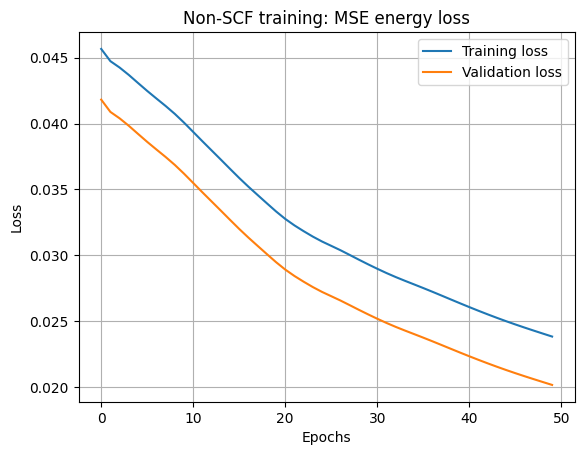

In [8]:
import matplotlib.pyplot as plt

plt.plot(tr_loss_his_non_sc_en, label="Training loss")
plt.plot(val_loss_his_non_sc_en, label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Non-SCF training: MSE energy loss")
plt.grid()
plt.legend()

and that's all there is! Remember, full BZ sampling is coming soon!